# Explore here

It's recommended to use this notebook for exploration purposes.

In [8]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
#PASO 1: Instalación de dependencias
#pip install pandas requests lxml

In [5]:
#PASO 2: Descargar HTML
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"

#Descargamos la pagina web en una variable
response = requests.get(url)

#Verificamos si la solicitud tuvo exito
print(response.status_code)


200


In [9]:
#PASO 3 Transforma el HTML

#En caso de que la solicitud fue correcta
if response.status_code == 200:
    # Extraer la tabla con pandas
    tables = pd.read_html(url)

    # Seleccionar la primera tabla encontrada
    df_songs = tables[0]

In [10]:
#PASO 4 Procesa el dataframe
# Ver nombres de columnas para confirmar su estructura
print("Columnas detectadas:", df_songs.columns)
    
# Renombrar columnas 
df_songs.rename(columns = {"Artist(s)":"Artist", "Streams (billions)": "Streams", "Release date": "release_date"}, inplace=True)
   
#Quitamos celdas vacias
df_songs = df_songs.dropna(subset=["Streams"])
    
#Limpiamos los datos 
df_songs["Streams"] = df_songs["Streams"].astype(str).str.replace("B", "", regex=True)
df_songs["Streams"] = pd.to_numeric(df_songs["Streams"], errors="coerce")

Columnas detectadas: Index(['Rank', 'Song', 'Artist(s)', 'Streams (billions)', 'Release date',
       'Ref.'],
      dtype='object')


In [11]:
#PASO 5 Almacena los datos en sqlite

# Conectar o crear la base de datos SQLite
conn = sqlite3.connect("spotify_songs.db")  # Crea el archivo .db si no existe

# Almacenar datos en SQLite
df_songs.to_sql("most_streamed", conn, if_exists="replace", index=False)
cursor = conn.cursor()

# Insert data into the database
cursor.execute("SELECT COUNT(*) FROM most_streamed")
print("Rows inserted:", cursor.fetchone()[0])

conn.commit()
conn.close()

Rows inserted: 101


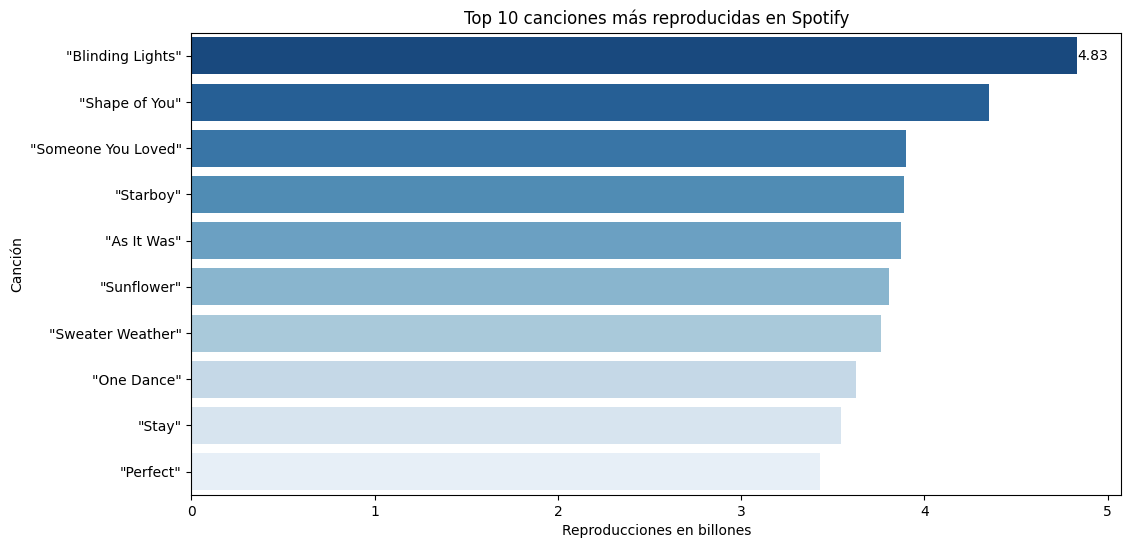

In [12]:
#PASO 6 Visualiza los datos (opcional, pero muy recomendado)
# Ordenar por Streams
df_sorted = df_songs.sort_values(by="Streams", ascending=False).head(10)

#Creamos grafica de barras
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Streams", y="Song", data=df_sorted, hue="Song", legend=False, palette="Blues_r")
   
# Agregar titulos y etiquetas
ax.text(df_sorted.iloc[0]["Streams"], 0, f"{df_sorted.iloc[0]['Streams']:.2f}", va="center", fontsize=10)
plt.xlabel("Reproducciones en billones")
plt.ylabel("Canción")
plt.title("Top 10 canciones más reproducidas en Spotify")
#Muestra grafica
plt.show()